In [5]:
%load_ext rpy2.ipython

In [2]:
%%R
library(DESeq2)
library(magrittr)
library(SummarizedExperiment)
library(dplyr)
library(DESeq2)
library(plotly)
library(ggplot2)
library(viridis)
library(magrittr)
library(pheatmap)
library(DescTools)
library(pdfCluster)
library(RColorBrewer)
library(SummarizedExperiment)
library(caret)
library(class)
library(htmlwidgets)
set.seed(88888888) # maximum luck

start_time <- Sys.time()

IN_DIR <- "/Users/kejiyuan/Desktop/reticula/data/tcdd/input/"
OUT_DIR <- "/Users/kejiyuan/Desktop/reticula/data/tcdd/output/"

GTEx_DATA_DIR <- IN_DIR
GTEx_DATA_FIL <- "rse_tcdd_data.Rdata"

ensembl2rxns.df <- read.table(paste(IN_DIR,"Ensembl2ReactomeReactions.txt",sep=""),
                              sep="\t")

load(paste(GTEx_DATA_DIR,GTEx_DATA_FIL,sep=""))

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    I, expand.grid, unname

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package: GenomeInfoDb
Loading require

In [ ]:
%%R

variances <- apply(assay(final_result), 1, var)

zero_variance_rows <- which(variances == 0)

if (length(zero_variance_rows) > 0) {
    deleted_data <- assay(final_result)[zero_variance_rows, , drop = FALSE]
    save(deleted_data, file=paste0(OUT_DIR, "deleted_data_90.RData"))
    new_assays <- assay(final_result)[-zero_variance_rows, , drop = FALSE]
    new_row_data <- rowData(final_result)[-zero_variance_rows, , drop = FALSE]

    new_final_result <- SummarizedExperiment(
        assays = SimpleList(counts = new_assays),
        rowData = new_row_data,
        colData = colData(final_result)
    )
    
    final_result <- new_final_result
    
    print(dim(assay(final_result)))
    print(dim(rowData(final_result)))
} else {
    cat("No rows with zero variance found.\n")
}

print(head(assay(final_result)))

[1] 43252   383
[1] 43252    11
                     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
ENSMUSG00000079800.2    0    0    0    0    0    0    0    0   49    49     0
ENSMUSG00000095092.1    0    0    0    0    0    0    0    0    0     0     0
ENSMUSG00000079192.2    0    0    0    0    0    0    0    0    0     0     0
ENSMUSG00000079794.2    0    0    0    0    0    0    0    0    0     0    50
ENSMUSG00000094799.1    0    0    0    0    0    0    0    0    0     0     0
ENSMUSG00000095250.1    0    0    0    0    0   50    0    0    0     0     0
                     [,12] [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20]
ENSMUSG00000079800.2    50     0    50    50     0     0     0     0     0
ENSMUSG00000095092.1     0     0     0     0     0     0     0     0     0
ENSMUSG00000079192.2     0     0     0     0     0     0     0     0     0
ENSMUSG00000079794.2     0     0     0     0     0     0     0     0     0
ENSMUSG00000094799.1     0     0     0     0   

ENSMUSG00000079192.2      0      0      0      0      0      0      0      0
ENSMUSG00000079794.2      0      0      0      0      0      0      0      0
ENSMUSG00000094799.1      0      0      0      0      0      0      0      0
ENSMUSG00000095250.1      0      0      0      0      0      0      0      0
                     [,262] [,263] [,264] [,265] [,266] [,267] [,268] [,269]
ENSMUSG00000079800.2      0      0      0      0      0    100    150     50
ENSMUSG00000095092.1      0      0      0      0      0      0      0      0
ENSMUSG00000079192.2      0      0      0      0      0      0      0      0
ENSMUSG00000079794.2      0      0      0      0      0      0      0      0
ENSMUSG00000094799.1      0      0      0      0      0      0      0      0
ENSMUSG00000095250.1      0      0      0      0      0      0      0      0
                     [,270] [,271] [,272] [,273] [,274] [,275] [,276] [,277]
ENSMUSG00000079800.2      0      0     50      0     50     40     34     49

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
%%R
library(tibble)

keep_samples <- colData(final_result)$dose %in% c(0.00, 30.00)

final_result <- final_result[, keep_samples]

temp_df <- as_tibble(colData(final_result)) %>%
  filter(!grepl("SRP131784", study))

tcdd_data <- temp_df
final_result <- final_result[, colData(final_result)$external_id %in% temp_df$external_id]

print(dim(final_result))
print(dim(tcdd_data))


[1] 43252   136
[1] 136 198


In [ ]:
%%R
sampling_percentage <- 0.90

tcdd_data_dose0 <- filter(tcdd_data, dose == 0)
tcdd_data_dose30 <- filter(tcdd_data, dose == 30)

final_results_list <- list()

for (i in 1:10) {
  min_count <- min(nrow(tcdd_data_dose0), nrow(tcdd_data_dose30)) * sampling_percentage
  min_count <- floor(min_count)  

  sampled_tcdd_dose0 <- sample_n(tcdd_data_dose0, size = min_count)
  sampled_tcdd_dose30 <- sample_n(tcdd_data_dose30, size = min_count)

  tcdd_data <- bind_rows(sampled_tcdd_dose0, sampled_tcdd_dose30)

  temp_final_result <- final_result[, colData(final_result)$external_id %in% tcdd_data$external_id]
  matched_indices <- match(tcdd_data$external_id, colData(temp_final_result)$external_id)
  temp_final_result <- temp_final_result[, matched_indices]

  final_results_list[[i]] <- temp_final_result

  print(paste("Iteration", i, "dimensions:"))
  print(dim(tcdd_data))
  print(dim(temp_final_result))
}


[1] "Iteration 1 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 2 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 3 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 4 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 5 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 6 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 7 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 8 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 9 dimensions:"
[1] 122 198
[1] 43252   122
[1] "Iteration 10 dimensions:"
[1] 122 198
[1] 43252   122


In [7]:
%%R
gtex_df <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/gtex/input/node_features2.txt",sep="")

In [ ]:
%%R
index = 0
for(final_result in final_results_list){
    print(paste("-----------------------round=", index, "---------------------",sep=""))
    tcdd_data <- colData(final_result)
    dose_counts <- table(tcdd_data$dose)
    dose_counts_df <- as.data.frame(dose_counts)
    colnames(dose_counts_df) <- c("Dose", "Count")
    combined_gender <- ifelse(tcdd_data$Sex != "", tcdd_data$Sex, tcdd_data$gender)
    write.table(tcdd_data$project_id,file=paste(OUT_DIR,"tcdd_project_id030_time_cross_90", index, ".txt",sep=""), row.names = FALSE, col.names = FALSE, sep = "\t")
    write.table(combined_gender,file=paste(OUT_DIR,"tcdd_gender030_time_cross_90",index,".txt",sep=""), row.names = FALSE, col.names = FALSE, sep = "\t")
    write.table(tcdd_data$external_id,file=paste(OUT_DIR,"tcdd_sample_id030_time_cross_90",index,".txt",sep=""), row.names = FALSE, col.names = FALSE, sep = "\t")
    write.table(tcdd_data$dose,file=paste(OUT_DIR,"tcdd_dose030_time_cross_90",index,".txt",sep=""), row.names = FALSE, col.names = FALSE, sep = "\t")
    tcdd.df <- final_result %>% SummarizedExperiment::assay() %>% as.data.frame()
    colnames(tcdd.df) <- colData(final_result)$external_id
    ensembl_wo_ids <- gsub("\\.[0-9]+","",rownames(tcdd.df))
    deleted_ensembl_wo_ids <- gsub("\\.[0-9]+","",rownames(deleted_data))
    rownames(tcdd.df) <- ensembl_wo_ids
    rownames(deleted_data) <- deleted_ensembl_wo_ids
    reactome_ensembl_ids <- intersect(ensembl2rxns.df$V1,ensembl_wo_ids)
    tcdd.df <- tcdd.df[reactome_ensembl_ids,]

    tcdd.dose.detail.vec <- tcdd_data$dose
    tcdd_dose_detail.vec <- tcdd_data$dose
    scale.factor <- (.Machine$integer.max - 1) / max(tcdd.df)
    tcdd.df <- round(tcdd.df * scale.factor)
    tcdd.df <- tcdd.df + 1
    dds <- DESeq2::DESeqDataSetFromMatrix(countData = as.matrix(tcdd.df),
                                      colData = data.frame(Sample=colnames(tcdd.df),
                                                           Dose=tcdd.dose.detail.vec),
                                      design = ~ Dose)
    vst.counts <- DESeq2::vst(dds,
                          blind = FALSE,
                          fitType = "local")
    ensembl2rxns.df <- read.table(paste(IN_DIR,"Ensembl2ReactomeReactions.txt",sep=""),
                              sep="\t")
    rxn2ensembls.nls <- list()
    rxns_w_tcdd_ensembls.df <- ensembl2rxns.df %>% dplyr::filter(V1 %in% reactome_ensembl_ids)
    rxns_w_tcdd_ensembls.df$V1 <- as.character(rxns_w_tcdd_ensembls.df$V1)
    rxns_w_tcdd_ensembls.df$V2 <- as.character(rxns_w_tcdd_ensembls.df$V2)


    for(i in 1:nrow(rxns_w_tcdd_ensembls.df)){
      ens_id <- rxns_w_tcdd_ensembls.df$V1[i]
      rxn_id <- rxns_w_tcdd_ensembls.df$V2[i]
    #     print(names(rxn2ensembls.nls))

      ensembl_list_for_rxn_id <- rxn2ensembls.nls[[rxn_id]]
      if(is.null(ensembl_list_for_rxn_id)){
    #     print("null")
        ensembl_list_for_rxn_id <- c(ens_id)
      }
      rxn2ensembls.nls[[rxn_id]] <- c(ensembl_list_for_rxn_id,ens_id) %>% unique()
    }
    
    N_FOLDS <- 10
    sample <- colData(vst.counts)
    vst.count.mtx <-
    vst.counts %>% SummarizedExperiment::assay() %>% as.data.frame()
    rxns <- rxn2ensembls.nls %>% names()
    rxn_knn_misclass_rate.nls <- list()
    rxn_knn_ari.nls <- list()
    rxn_knn_ecount.nls <- list()
    rxn_pca.nls <- list()
    count <- 0
    toi_indices <- seq(1,length(tcdd_dose_detail.vec))
    tcdd_dose_detail_vec_tis_of_interest <-
    tcdd_dose_detail.vec[toi_indices]
    vst.count.mtx.tis_of_interest <- vst.count.mtx[, toi_indices]
    training_indices <-
       caret::createDataPartition(
          tcdd_dose_detail_vec_tis_of_interest,
          times = 1,
          p = 1.0, # no data will be held out when set to "1.0"
          list = FALSE
       )
    vst.count.mtx.train <-
    vst.count.mtx.tis_of_interest[, training_indices] #9/10ths of data
    vst.count.mtx.test  <-
    vst.count.mtx.tis_of_interest[, -training_indices] #1/10th of data
    tcdd_dose_detail.vec.train <- tcdd_dose_detail_vec_tis_of_interest[training_indices]

    Y <- tcdd_dose_detail.vec.train
    X <- readRDS(paste(OUT_DIR, "rxn_pca_nls030_time_cross_90",index,".Rds", sep = ""))
    E <- read.table(paste(IN_DIR,"ReactionNetwork_Rel.txt",sep=""))
    rxn2nodeLabel.nls <- list()
    nodeLabel2rxn.nls <- list()
    for(i in 1:length(X)){
      rxn2nodeLabel.nls[[names(X)[i]]] <- i
      nodeLabel2rxn.nls[[i]] <- names(X)[i]
    }
    E <- E %>%
    dplyr::filter(V1 %in% names(rxn2nodeLabel.nls))
    E <- E %>%
    dplyr::filter(V3 %in% names(rxn2nodeLabel.nls))
    E <- E %>%
    dplyr::filter(V1 %in% names(rxn2nodeLabel.nls)) %>%
    dplyr::filter(V3 %in% names(rxn2nodeLabel.nls)) %>%
    dplyr::select(V1,V3)
    node1 <- numeric()
    node2 <- numeric()
    for(i in 1:nrow(E)){
      node1 <- c(node1,rxn2nodeLabel.nls[[as.character(E$V1[i])]])
      node2 <- c(node2,rxn2nodeLabel.nls[[as.character(E$V3[i])]])
    }
    z <- unlist(rxn2nodeLabel.nls)
    y <- unlist(nodeLabel2rxn.nls)
    E <- data.frame(node1 = node1,
                node2 = node2)
    X <- as.data.frame(X)
    Y <- as.data.frame(Y)
    missing_in_gtex <- setdiff(names(gtex_df), names(X))
    missing_pathway <- data.frame(missing_pathway = missing_in_gtex)
    all_values <- as.vector(as.matrix(X))
    median_value <- median(all_values, na.rm = TRUE)
    for (col in missing_pathway$missing_pathway) {
      X[[col]] <- median_value
    }

    write.table(X,
          file=paste(IN_DIR,"node_features030_2_time_cross_90", index, ".txt",sep=""),
          row.names = FALSE,
          col.names = FALSE)
    write.table(Y,
              file=paste(IN_DIR,"graph_targets030_time_cross_90", index, ".txt",sep=""),
              row.names = FALSE,
              col.names = FALSE)
    index <- index + 1
}
print("finished")

[1] "-----------------------round=0---------------------"
[1] "-----------------------round=1---------------------"
[1] "-----------------------round=2---------------------"
[1] "-----------------------round=3---------------------"
[1] "-----------------------round=4---------------------"
[1] "-----------------------round=5---------------------"
[1] "-----------------------round=6---------------------"
[1] "-----------------------round=7---------------------"
[1] "-----------------------round=8---------------------"
[1] "-----------------------round=9---------------------"
[1] "finished"


converting counts to integer mode
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.
converting counts to integer mode
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
  the design formula contains one or more numeric varia

In [6]:
import os.path as op
import random
import time

import matplotlib.pyplot as plt
import numpy
import sklearn
import torch
import torch.nn.functional as nn_func
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score
from torch.nn import Linear
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, global_mean_pool

INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 26
NEW_CHANNELS = 2
HIDDEN_CHANNELS = 64
BATCH_SIZE = 64
BENCHMARKING = False
EPOCHS = 500

random.seed = 88888888

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()

        self.conv1 = GraphConv(INPUT_CHANNELS, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, OUTPUT_CHANNELS)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = nn_func.dropout(x, training=self.training)
        x = self.lin(x)

        return x


def read_reactome_graph(e_fn):
    e_v1 = []
    e_v2 = []

    for line in open(e_fn, 'r'):
        dt = line.split()
        node1 = int(dt[0]) - 1  # subtracting to convert R idx to python idx
        node2 = int(dt[1]) - 1  # " "
        e_v1.append(node1)
        e_v2.append(node2)

    return e_v1, e_v2


def build_reactome_graph_datalist(e_v1, e_v2, n_fn, g_fn, pid_fn, sid_fn, gen_fn, dose_fn):
    edge_index = torch.tensor([e_v1, e_v2], dtype=torch.long)
    feature_v = numpy.loadtxt(n_fn)
    target_v = numpy.loadtxt(g_fn, dtype=float, delimiter=",")
    projectID_v = numpy.loadtxt(pid_fn, dtype=str, delimiter="\t")
    sampleID_v = numpy.loadtxt(sid_fn, dtype=str, delimiter="\t")
    gender_v = numpy.loadtxt(gen_fn, dtype=str, delimiter="\t")
    dose_v = numpy.loadtxt(dose_fn, dtype=str, delimiter="\t")
    
    binary_labels = (target_v > 0).astype(int)
    
    print("labels check:")
    for dose, label in zip(target_v[:10], binary_labels[:10]): 
        print(f"dose: {dose}, label: {label}")


    d_list = []
    for row_idx in range(len(feature_v)):
        features = feature_v[row_idx, :]
        x = torch.tensor(features, dtype=torch.float)
        x = x.unsqueeze(1)
#         y = torch.tensor([target_v[row_idx]])
        y = torch.tensor([binary_labels[row_idx]], dtype=torch.long)
        
        pid = projectID_v[row_idx]
        sid = sampleID_v[row_idx]
        gen = gender_v[row_idx]
        dose = dose_v[row_idx]
        
        d_list.append(Data(x=x, y=y, pid=pid, sid=sid, gen=gen, dose=dose, edge_index=edge_index))

    return d_list


def build_reactome_graph_loader(d_list, batch_size):
    loader = DataLoader(d_list, batch_size=batch_size, shuffle=False)  # True)

    return loader


def train(loader, dv):
    model.train()

    correct = 0
    for batch in loader:  # Iterate in batches over the training dataset.
        batch.validate()
        x = batch.x.to(dv)
        e = batch.edge_index.to(dv)
        b = batch.batch.to(dv)
        y = batch.y.to(dv)

        out = model(x, e, b)  # Perform a single forward pass.
        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


def test(loader, dv):
    model.eval()

    targets = []
    predictions = []
    project_ids = []
    sample_ids = []
    genders = []
    doses = []
    confidences = []
    for batch in loader:  # Iterate in batches over the test dataset.
        x = batch.x.to(dv)
        e = batch.edge_index.to(dv)
        b = batch.batch.to(dv)
        y = batch.y.to(dv)
        targets += torch.Tensor.tolist(y)
        
        project_ids += batch.pid
        sample_ids += batch.sid
        genders += batch.gen
        doses += batch.dose
        
        out = model(x, e, b)  # Perform a single forward pass.
        prob = torch.softmax(out, dim=1)
        
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        predictions += torch.Tensor.tolist(pred)
        confidences += torch.Tensor.tolist(prob)
        
    num_classes = len(confidences[0])

    data_to_save = []
    for i in range(len(targets)):
        row = [project_ids[i], sample_ids[i], genders[i], doses[i], targets[i], predictions[i]] + confidences[i]
        data_to_save.append(row)
    data_to_save = numpy.array(data_to_save)
    print(data_to_save)
    
    fmt = ['%s', '%s', '%s', '%s', '%s', '%s'] + ['%s' for _ in range(num_classes)]
    
    headers = ['project_ids', 'sample_ids', 'genders', 'doses', 'target', 'prediction'] + [f'confidence_class_{i}' for i in range(num_classes)]
    numpy.savetxt(output_fn, data_to_save, fmt='\t'.join(fmt), delimiter='\t', header='\t'.join(headers), comments='')
        
    ari = adjusted_rand_score(targets, predictions)
    print(f'ari: {ari}')
    return ari

In [13]:
for i in range(10):
    node_features_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/input/node_features030_2_time_cross_90{i}.txt'
    graph_targets_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/input/graph_targets030_time_cross_90{i}.txt'
    edges_fn = '/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/gtex/input/edges.txt'
    model_fn = '/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/gtex/GNN/trained_pytorch_model_rewired10_fold_full_dataset.pt'
    output_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/predictions030_time_cross_90{i}.tsv'
    sample_id_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/tcdd_sample_id030_time_cross_90{i}.txt'
    project_id_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/tcdd_project_id030_time_cross_90{i}.txt'
    gender_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/tcdd_gender030_time_cross_90{i}.txt'
    dose_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/tcdd_dose030_time_cross_90{i}.txt'
    # test graph_targets.txt, node_features.txt and edges.txt
    features_exist = op.exists(node_features_fn)
    targets_exist = op.exists(graph_targets_fn)
    edges_exist = op.exists(edges_fn)
    model_exists = op.exists(model_fn)

    def change_key(self, old, new):
        for _ in range(len(self)):
            k, v = self.popitem(False)
            self[new if old == k else k] = v

    (edge_v1, edge_v2) = read_reactome_graph(edges_fn)
    model = GNN(hidden_channels=HIDDEN_CHANNELS)
    device = cpu = torch.device('cpu')

    sd = torch.load(model_fn, map_location=device)
    change_key(sd, 'conv1.lin_l.weight', 'conv1.lin_rel.weight')
    change_key(sd, 'conv1.lin_l.bias', 'conv1.lin_rel.bias')
    change_key(sd, 'conv1.lin_r.weight', 'conv1.lin_root.weight')
    change_key(sd, 'conv2.lin_l.weight', 'conv2.lin_rel.weight')
    change_key(sd, 'conv2.lin_l.bias', 'conv2.lin_rel.bias')
    change_key(sd, 'conv2.lin_r.weight', 'conv2.lin_root.weight')
    change_key(sd, 'conv3.lin_l.weight', 'conv3.lin_rel.weight')
    change_key(sd, 'conv3.lin_l.bias', 'conv3.lin_rel.bias')
    change_key(sd, 'conv3.lin_r.weight', 'conv3.lin_root.weight')
    change_key(sd, 'lin.weight', 'lin.weight')
    change_key(sd, 'lin.bias', 'lin.bias')

    model.load_state_dict(sd)
    model.eval()
    
    # replace final layer with new shape matching new dataset
    model.lin = Linear(HIDDEN_CHANNELS, NEW_CHANNELS)

    model.conv1.lin_rel.weight.requires_grad = False
    model.conv1.lin_rel.bias.requires_grad = False
    model.conv1.lin_root.weight.requires_grad = False
    model.conv2.lin_rel.weight.requires_grad = False
    model.conv2.lin_rel.bias.requires_grad = False
    model.conv2.lin_root.weight.requires_grad = False
    model.conv3.lin_rel.weight.requires_grad = False
    model.conv3.lin_rel.bias.requires_grad = False
    model.conv3.lin_root.weight.requires_grad = False
    model.lin.weight.requires_grad = True
    model.lin.bias.requires_grad = True

    # for name, param in model.named_parameters(): print(name, param)

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
    criterion = torch.nn.CrossEntropyLoss()
    
    data_list = build_reactome_graph_datalist(edge_v1, edge_v2, node_features_fn, graph_targets_fn, project_id_fn, sample_id_fn, gender_fn, dose_fn)
    # retrain model for fine tuning transfer learning
    train_data_list = data_list  # all data
    print(len(train_data_list))
    print(f'Number of training graphs: {len(train_data_list)}')
    train_data_loader = build_reactome_graph_loader(train_data_list, BATCH_SIZE)
    for epoch in range(EPOCHS):
        train(train_data_loader, device)
        train_acc = train(train_data_loader, device)
        print(f'Epoch: {epoch}, Train Acc: {train_acc}')
        if train_acc == 1.0:
            break

    final_ari = test(train_data_loader, device)
    print(f'test_ari: {final_ari}')

    model_save_name = f'tuned_pytorch_tcdd_model030_time_cross_90{i}.pt'
    path = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/{model_save_name}'
    torch.save(model.state_dict(), path)
    print(f'model saved as {path}')

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.5655737704918032
Epoch: 1, Train Acc: 0.819672131147541
Epoch: 2, Train Acc: 0.8688524590163934
Epoch: 3, Train Acc: 0.9262295081967213
Epoch: 4, Train Acc: 0.9262295081967213
Epoch: 5, Train Acc: 0.9426229508196722
Epoch: 6, Train Acc: 0.9508196721311475
Epoch: 7, Train Acc: 0.9508196721311475
Epoch: 8, Train Acc: 0.9508196721311475
Epoch: 9, Train Acc: 0.9590163934426229
Epoch: 10, Train Acc: 0.9590163934426229
Epoch: 11, Train Acc: 0.9590163934426229
Epoch: 12, Train Acc: 0.9590163934426229
Epoch: 13, Train Acc: 0.9672131147540983
Epoch: 14, Train Acc: 0.9672131147540983
Epoch: 15, Train Acc: 0.9672131147540983
Epoch: 16, Train Acc: 0.9672131147540983
Epoch: 17, Train Acc: 0.9672131147540983
Epoch: 18, Train Acc: 0.9754098360655737
Epoch: 19, Train Acc: 0.9754098360655737
Epoch: 20, Train Acc: 0.9754098360655737
Epoch: 21, Train Acc: 0.9836065573770492
Epoch: 22, Train Acc: 0.9836065573770492
Epoch: 23, Train Acc: 0.9836065573770492
Epoch: 24, Train Acc: 0.983

Epoch: 198, Train Acc: 0.9918032786885246
Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.5
Epoch: 1, Train Acc: 0.6639344262295082
Epoch: 2, Train Acc: 0.860655737704918
Epoch: 3, Train Acc: 0.9262295081967213
Epoch: 4, Train Acc: 0.9262295081967213
Epoch: 5, Train Acc: 0.9344262295081968
Epoch: 6, Train Acc: 0.9426229508196722
Epoch: 7, Train Acc: 0.9426229508196722
Epoch: 8, Train Acc: 0.9426229508196722
Epoch: 9, Train Acc: 0.9426229508196722
Epoch: 10, Train Acc: 0.9508196721311475
Epoch: 11, Train Acc: 0.9508196721311475
Epoch: 12, Train Acc: 0.9508196721311475
Epoch: 13, Train Acc: 0.9508196721311475
Epoch: 14, Train Acc: 0.9508196721311475
Epoch: 15, Train Acc: 0.9508196721311475
Epoch: 16, Train Acc: 0.9508196721311475
Epoch: 17, Train Acc: 0.9508196721311475
Epoch: 18, Train Acc: 0.9508196721311475
Epoch: 19, Train Acc: 0.9508196721311475
Epoch: 20, Train Acc: 0.9508196721311475
Epoch: 21, Train Acc: 0.9508196721311475
Epoch: 22, Train Acc: 0.9508196721311475
Epoch: 23, Train Acc: 0.9508196721311475
Epoch: 24, Train Acc: 0.9508196721311475
E

Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.9918032786885246
Epoch: 222, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.8852459016393442
Epoch: 1, Train Acc: 0.9754098360655737
Epoch: 2, Train Acc: 0.9836065573770492
Epoch: 3, Train Acc: 0.9918032786885246
Epoch: 4, Train Acc: 0.9836065573770492
Epoch: 5, Train Acc: 0.9754098360655737
Epoch: 6, Train Acc: 0.9754098360655737
Epoch: 7, Train Acc: 0.9754098360655737
Epoch: 8, Train Acc: 0.9754098360655737
Epoch: 9, Train Acc: 0.9754098360655737
Epoch: 10, Train Acc: 0.9754098360655737
Epoch: 11, Train Acc: 0.9754098360655737
Epoch: 12, Train Acc: 0.9754098360655737
Epoch: 13, Train Acc: 0.9754098360655737
Epoch: 14, Train Acc: 0.9754098360655737
Epoch: 15, Train Acc: 0.9754098360655737
Epoch: 16, Train Acc: 0.9754098360655737
Epoch: 17, Train Acc: 0.9754098360655737
Epoch: 18, Train Acc: 0.9754098360655737
Epoch: 19, Train Acc: 0.9754098360655737
Epoch: 20, Train Acc: 0.9754098360655737
Epoch: 21, Train Acc: 0.9754098360655737
Epoch: 22, Train Acc: 0.9754098360655737
Epoch: 23, Train Acc: 0.9836065573770492
Epoch: 24, Train Acc: 0.98

Epoch: 198, Train Acc: 0.9918032786885246
Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.6311475409836066
Epoch: 1, Train Acc: 0.7622950819672131
Epoch: 2, Train Acc: 0.9508196721311475
Epoch: 3, Train Acc: 0.9672131147540983
Epoch: 4, Train Acc: 0.9672131147540983
Epoch: 5, Train Acc: 0.9672131147540983
Epoch: 6, Train Acc: 0.9672131147540983
Epoch: 7, Train Acc: 0.9672131147540983
Epoch: 8, Train Acc: 0.9672131147540983
Epoch: 9, Train Acc: 0.9672131147540983
Epoch: 10, Train Acc: 0.9672131147540983
Epoch: 11, Train Acc: 0.9672131147540983
Epoch: 12, Train Acc: 0.9672131147540983
Epoch: 13, Train Acc: 0.9672131147540983
Epoch: 14, Train Acc: 0.9672131147540983
Epoch: 15, Train Acc: 0.9672131147540983
Epoch: 16, Train Acc: 0.9754098360655737
Epoch: 17, Train Acc: 0.9754098360655737
Epoch: 18, Train Acc: 0.9754098360655737
Epoch: 19, Train Acc: 0.9754098360655737
Epoch: 20, Train Acc: 0.9754098360655737
Epoch: 21, Train Acc: 0.9836065573770492
Epoch: 22, Train Acc: 0.9918032786885246
Epoch: 23, Train Acc: 0.9918032786885246
Epoch: 24, Train Acc: 0.99

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.5
Epoch: 1, Train Acc: 0.5081967213114754
Epoch: 2, Train Acc: 0.7540983606557377
Epoch: 3, Train Acc: 0.9672131147540983
Epoch: 4, Train Acc: 0.9836065573770492
Epoch: 5, Train Acc: 0.9918032786885246
Epoch: 6, Train Acc: 0.9918032786885246
Epoch: 7, Train Acc: 0.9918032786885246
Epoch: 8, Train Acc: 0.9918032786885246
Epoch: 9, Train Acc: 0.9918032786885246
Epoch: 10, Train Acc: 0.9918032786885246
Epoch: 11, Train Acc: 0.9918032786885246
Epoch: 12, Train Acc: 0.9918032786885246
Epoch: 13, Train Acc: 0.9918032786885246
Epoch: 14, Train Acc: 0.9918032786885246
Epoch: 15, Train Acc: 0.9918032786885246
Epoch: 16, Train Acc: 0.9918032786885246
Epoch: 17, Train Acc: 0.9918032786885246
Epoch: 18, Train Acc: 0.9918032786885246
Epoch: 19, Train Acc: 0.9918032786885246
Epoch: 20, Train Acc: 0.9918032786885246
Epoch: 21, Train Acc: 0.9918032786885246
Epoch: 22, Train Acc: 0.9918032786885246
Epoch: 23, Train Acc: 0.9918032786885246
Epoch: 24, Train Acc: 0.9918032786885246


labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.1557377049180328
Epoch: 1, Train Acc: 0.2459016393442623
Epoch: 2, Train Acc: 0.47540983606557374
Epoch: 3, Train Acc: 0.5
Epoch: 4, Train Acc: 0.7131147540983607
Epoch: 5, Train Acc: 0.9590163934426229
Epoch: 6, Train Acc: 0.9672131147540983
Epoch: 7, Train Acc: 0.9672131147540983
Epoch: 8, Train Acc: 0.9672131147540983
Epoch: 9, Train Acc: 0.9672131147540983
Epoch: 10, Train Acc: 0.9590163934426229
Epoch: 11, Train Acc: 0.9590163934426229
Epoch: 12, Train Acc: 0.9590163934426229
Epoch: 13, Train Acc: 0.9590163934426229
Epoch: 14, Train Acc: 0.9590163934426229
Epoch: 15, Train Acc: 0.9590163934426229
Epoch: 16, Train Acc: 0.9590163934426229
Epoch: 17, Train Acc: 0.9590163934426229
Epoch: 18, Train Acc: 0.9590163934426229
Epoch: 19, Train Acc: 0.9590163934426229
Epoch: 20, Train Acc: 0.9590163934426229
Epoch: 21, Train Acc: 0.9672131147540983
Epoch: 22, Train Acc: 0.9672131147540983
Epoch: 23, Train Acc: 0.9672131147540983
Epoch: 24, Train Acc: 0.9672131147540983

Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.9918032786885246
Epoch: 222, Train Acc: 0.991803278

Epoch: 395, Train Acc: 0.9918032786885246
Epoch: 396, Train Acc: 0.9918032786885246
Epoch: 397, Train Acc: 0.9918032786885246
Epoch: 398, Train Acc: 0.9918032786885246
Epoch: 399, Train Acc: 0.9918032786885246
Epoch: 400, Train Acc: 0.9918032786885246
Epoch: 401, Train Acc: 0.9918032786885246
Epoch: 402, Train Acc: 0.9918032786885246
Epoch: 403, Train Acc: 0.9918032786885246
Epoch: 404, Train Acc: 0.9918032786885246
Epoch: 405, Train Acc: 0.9918032786885246
Epoch: 406, Train Acc: 0.9918032786885246
Epoch: 407, Train Acc: 0.9918032786885246
Epoch: 408, Train Acc: 0.9918032786885246
Epoch: 409, Train Acc: 0.9918032786885246
Epoch: 410, Train Acc: 0.9918032786885246
Epoch: 411, Train Acc: 0.9918032786885246
Epoch: 412, Train Acc: 0.9918032786885246
Epoch: 413, Train Acc: 0.9918032786885246
Epoch: 414, Train Acc: 0.9918032786885246
Epoch: 415, Train Acc: 0.9918032786885246
Epoch: 416, Train Acc: 0.9918032786885246
Epoch: 417, Train Acc: 0.9918032786885246
Epoch: 418, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.8852459016393442
Epoch: 1, Train Acc: 0.9344262295081968
Epoch: 2, Train Acc: 0.9426229508196722
Epoch: 3, Train Acc: 0.9426229508196722
Epoch: 4, Train Acc: 0.9426229508196722
Epoch: 5, Train Acc: 0.9426229508196722
Epoch: 6, Train Acc: 0.9426229508196722
Epoch: 7, Train Acc: 0.9426229508196722
Epoch: 8, Train Acc: 0.9508196721311475
Epoch: 9, Train Acc: 0.9508196721311475
Epoch: 10, Train Acc: 0.9508196721311475
Epoch: 11, Train Acc: 0.9508196721311475
Epoch: 12, Train Acc: 0.9508196721311475
Epoch: 13, Train Acc: 0.9508196721311475
Epoch: 14, Train Acc: 0.9508196721311475
Epoch: 15, Train Acc: 0.9508196721311475
Epoch: 16, Train Acc: 0.9508196721311475
Epoch: 17, Train Acc: 0.9508196721311475
Epoch: 18, Train Acc: 0.9508196721311475
Epoch: 19, Train Acc: 0.9508196721311475
Epoch: 20, Train Acc: 0.9508196721311475
Epoch: 21, Train Acc: 0.9508196721311475
Epoch: 22, Train Acc: 0.9508196721311475
Epoch: 23, Train Acc: 0.9508196721311475
Epoch: 24, Train Acc: 0.95

Epoch: 198, Train Acc: 0.9918032786885246
Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.5
Epoch: 1, Train Acc: 0.5
Epoch: 2, Train Acc: 0.5655737704918032
Epoch: 3, Train Acc: 0.860655737704918
Epoch: 4, Train Acc: 0.9098360655737705
Epoch: 5, Train Acc: 0.9180327868852459
Epoch: 6, Train Acc: 0.9262295081967213
Epoch: 7, Train Acc: 0.9344262295081968
Epoch: 8, Train Acc: 0.9344262295081968
Epoch: 9, Train Acc: 0.9426229508196722
Epoch: 10, Train Acc: 0.9426229508196722
Epoch: 11, Train Acc: 0.9426229508196722
Epoch: 12, Train Acc: 0.9426229508196722
Epoch: 13, Train Acc: 0.9426229508196722
Epoch: 14, Train Acc: 0.9426229508196722
Epoch: 15, Train Acc: 0.9508196721311475
Epoch: 16, Train Acc: 0.9508196721311475
Epoch: 17, Train Acc: 0.9508196721311475
Epoch: 18, Train Acc: 0.9508196721311475
Epoch: 19, Train Acc: 0.9508196721311475
Epoch: 20, Train Acc: 0.9590163934426229
Epoch: 21, Train Acc: 0.9672131147540983
Epoch: 22, Train Acc: 0.9672131147540983
Epoch: 23, Train Acc: 0.9754098360655737
Epoch: 24, Train Acc: 0.9754098360655737
Epoch: 25, Train

Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.9918032786885246
Epoch: 222, Train Acc: 0.991803278

Epoch: 395, Train Acc: 0.9918032786885246
Epoch: 396, Train Acc: 1.0
[['"SRP161461"' '"SRR7817613"' '"male"' '0' '0' '0' '0.9999825954437256'
  '1.736582453304436e-05']
 ['"SRP161461"' '"SRR7817625"' '"male"' '0' '0' '0' '0.999981164932251'
  '1.8834654838428833e-05']
 ['"SRP161461"' '"SRR7817611"' '"male"' '0' '0' '0' '0.9997324347496033'
  '0.00026758023886941373']
 ['"SRP161461"' '"SRR7817659"' '"male"' '0' '0' '0' '0.9998395442962646'
  '0.00016038912872318178']
 ['"SRP161461"' '"SRR7817660"' '"male"' '0' '0' '0' '0.9998558759689331'
  '0.00014409571303986013']
 ['"SRP090688"' '"SRR4317608"' '"male"' '0' '0' '0' '0.9768784642219543'
  '0.023121464997529984']
 ['"SRP090688"' '"SRR4317612"' '"male"' '0' '0' '0' '0.9781109094619751'
  '0.021889012306928635']
 ['"SRP075814"' '"SRR3593526"' '"female"' '0' '0' '0'
  '0.9938564896583557' '0.006143443752080202']
 ['"SRP161461"' '"SRR7817635"' '"male"' '0' '0' '0' '0.9999473094940186'
  '5.265583604341373e-05']
 ['"SRP161461"' '"SRR7817648"

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.5409836065573771
Epoch: 1, Train Acc: 0.7377049180327869
Epoch: 2, Train Acc: 0.9836065573770492
Epoch: 3, Train Acc: 0.9918032786885246
Epoch: 4, Train Acc: 0.9836065573770492
Epoch: 5, Train Acc: 0.9836065573770492
Epoch: 6, Train Acc: 0.9836065573770492
Epoch: 7, Train Acc: 0.9836065573770492
Epoch: 8, Train Acc: 0.9754098360655737
Epoch: 9, Train Acc: 0.9754098360655737
Epoch: 10, Train Acc: 0.9754098360655737
Epoch: 11, Train Acc: 0.9754098360655737
Epoch: 12, Train Acc: 0.9754098360655737
Epoch: 13, Train Acc: 0.9754098360655737
Epoch: 14, Train Acc: 0.9754098360655737
Epoch: 15, Train Acc: 0.9754098360655737
Epoch: 16, Train Acc: 0.9754098360655737
Epoch: 17, Train Acc: 0.9754098360655737
Epoch: 18, Train Acc: 0.9754098360655737
Epoch: 19, Train Acc: 0.9754098360655737
Epoch: 20, Train Acc: 0.9754098360655737
Epoch: 21, Train Acc: 0.9754098360655737
Epoch: 22, Train Acc: 0.9754098360655737
Epoch: 23, Train Acc: 0.9754098360655737
Epoch: 24, Train Acc: 0.98

Epoch: 198, Train Acc: 0.9918032786885246
Epoch: 199, Train Acc: 0.9918032786885246
Epoch: 200, Train Acc: 0.9918032786885246
Epoch: 201, Train Acc: 0.9918032786885246
Epoch: 202, Train Acc: 0.9918032786885246
Epoch: 203, Train Acc: 0.9918032786885246
Epoch: 204, Train Acc: 0.9918032786885246
Epoch: 205, Train Acc: 0.9918032786885246
Epoch: 206, Train Acc: 0.9918032786885246
Epoch: 207, Train Acc: 0.9918032786885246
Epoch: 208, Train Acc: 0.9918032786885246
Epoch: 209, Train Acc: 0.9918032786885246
Epoch: 210, Train Acc: 0.9918032786885246
Epoch: 211, Train Acc: 0.9918032786885246
Epoch: 212, Train Acc: 0.9918032786885246
Epoch: 213, Train Acc: 0.9918032786885246
Epoch: 214, Train Acc: 0.9918032786885246
Epoch: 215, Train Acc: 0.9918032786885246
Epoch: 216, Train Acc: 0.9918032786885246
Epoch: 217, Train Acc: 0.9918032786885246
Epoch: 218, Train Acc: 0.9918032786885246
Epoch: 219, Train Acc: 0.9918032786885246
Epoch: 220, Train Acc: 0.9918032786885246
Epoch: 221, Train Acc: 0.991803278

labels check:
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
dose: 0.0, label: 0
122
Number of training graphs: 122


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Acc: 0.39344262295081966
Epoch: 1, Train Acc: 0.7786885245901639
Epoch: 2, Train Acc: 0.9180327868852459
Epoch: 3, Train Acc: 0.9836065573770492
Epoch: 4, Train Acc: 1.0
[['"SRP049440"' '"SRR1636592"' '"female"' '0' '0' '0'
  '0.7575586438179016' '0.2424413561820984']
 ['"SRP161461"' '"SRR7817673"' '"male"' '0' '0' '0' '0.6839213967323303'
  '0.3160786032676697']
 ['"SRP161461"' '"SRR7817636"' '"male"' '0' '0' '0' '0.7733164429664612'
  '0.2266835719347']
 ['"SRP161461"' '"SRR7817660"' '"male"' '0' '0' '0' '0.758773684501648'
  '0.24122631549835205']
 ['"SRP161461"' '"SRR7817672"' '"male"' '0' '0' '0' '0.5430710911750793'
  '0.45692890882492065']
 ['"SRP161461"' '"SRR7817615"' '"male"' '0' '0' '0' '0.7624183297157288'
  '0.23758170008659363']
 ['"SRP075814"' '"SRR3593526"' '"female"' '0' '0' '0'
  '0.6638525128364563' '0.3361474573612213']
 ['"SRP161461"' '"SRR7817613"' '"male"' '0' '0' '0' '0.7888588309288025'
  '0.21114122867584229']
 ['"SRP161461"' '"SRR7817675"' '"m

In [8]:
import os.path as op
import time
import torch
import numpy
import random
import sklearn
import numpy as np
import networkx as nx
import torch.nn.functional as F
from torch.nn import Linear
from sklearn import preprocessing
from collections import defaultdict
from IPython.display import Javascript
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data, DataLoader
from captum.attr import Saliency, IntegratedGradients
from torch_geometric.nn import GraphConv, global_mean_pool

In [9]:
# magic numbers
INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 2
HIDDEN_CHANNELS = 64

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()

        self.conv1 = GraphConv(INPUT_CHANNELS, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, OUTPUT_CHANNELS)

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, training=self.training)
        x = self.lin(x)

        return x


def read_reactome_graph(e_fn):
    e_v1 = []
    e_v2 = []

    for line in open(e_fn, 'r'):
        dt = line.split()
        node1 = int(dt[0]) - 1  # subtracting to convert R idx to python idx
        node2 = int(dt[1]) - 1  # " "
        e_v1.append(node1)
        e_v2.append(node2)

    return e_v1, e_v2


def build_reactome_graph_datalist(e_v1, e_v2, n_features_fn, g_targets_fn):
    edge_index = torch.tensor([e_v1, e_v2], dtype=torch.long)
    feature_v = numpy.loadtxt(n_features_fn)
    t_v = numpy.loadtxt(g_targets_fn, dtype=float, delimiter=",")

#     t_encoder = sklearn.preprocessing.LabelEncoder()
#     t_v = t_encoder.fit_transform(t_v)

    binary_labels = (t_v > 0).astype(int)

    d_list = []
    for row_idx in range(len(feature_v)):
        x = torch.tensor(feature_v[row_idx, :], dtype=torch.float)
        x = x.unsqueeze(1)
#         y = torch.tensor([t_v[row_idx]])
        y = torch.tensor([binary_labels[row_idx]], dtype=torch.long)
        d_list.append(Data(x=x, y=y, edge_index=edge_index))

    return d_list


def explain(m, dt, target):
    input_mask = torch.ones(dt.edge_index.shape[1]).requires_grad_(True).to(device)
    if m == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(dt,),
                            internal_batch_size=dt.edge_index.shape[1])
    else:
        raise Exception('Unknown explanation method')

    e_mask = np.abs(mask.cpu().detach().numpy())
    if e_mask.max() > 0:  # avoid division by zero
        e_mask = e_mask / e_mask.max()
    return e_mask


def aggregate_edge_directions(e_mask, dt):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(e_mask, *dt.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict


def model_forward(e_mask, dt):
    batch = torch.zeros(dt.x.shape[0], dtype=int).to(device)
    out = model(dt.x,
                dt.edge_index,
                batch,
                e_mask)
    return out

In [10]:
for i in range(10):
    node_features_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/input/node_features030_2_time_cross_90{i}.txt'
    graph_targets_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/input/graph_targets030_time_cross_90{i}.txt'
    edges_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/gtex/input/edges.txt'
    model_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/tuned_pytorch_tcdd_model030_time_cross_90{i}.pt'
    output_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/predictions030_time_cross_90{i}.tsv'
    transformed_targets_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_90{i}.txt'
    inverted_targets_fn = f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_90{i}.txt'
    
    (edge_v1, edge_v2) = read_reactome_graph(edges_fn)

    data_list = build_reactome_graph_datalist(edge_v1, edge_v2, node_features_fn, graph_targets_fn)
    data_loader = DataLoader(data_list)

    # rebuild label encoder to invert numerical transformation
    target_v = numpy.loadtxt(graph_targets_fn, dtype=str, delimiter=",")
    target_encoder = sklearn.preprocessing.LabelEncoder()

    target_v = target_encoder.fit_transform(target_v)
    path = transformed_targets_fn
    numpy.savetxt(path, target_v, delimiter=",", fmt="%.0f")
    print(F"target_v saved as {path}")

    target_l = target_encoder.inverse_transform(target_v)
    path = inverted_targets_fn
    numpy.savetxt(path, target_l, delimiter=",", fmt="%s")
    print(F"target_l saved as {path}")

    model = GNN(hidden_channels=HIDDEN_CHANNELS)
    device = cpu = torch.device('cpu')
    model = model.to(device)
    path = model_fn
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    d = data_loader.dataset[0]
    d.edge_index.shape[1]

    data = data_loader.dataset[0]

    for target_tissue in range(2):
        title = 'Integrated Gradients'
        method = 'ig'
        data.to(device)
        print(F"processing tissue {target_tissue} with {title}, a.k.a. {method}")
        edge_mask = explain(method, data, target=target_tissue)
        # edge_mask_dict = aggregate_edge_directions(edge_mask, data)
        path = f"/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/{method}_{target_tissue}030_time_cross_90{i}.txt"
        numpy.savetxt(path, edge_mask, delimiter=",")
        print(F"{method} {target_tissue} edges saved as {path}")


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_900.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_900.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_900.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_900.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_901.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_901.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_901.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_901.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_902.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_902.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_902.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_902.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_903.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_903.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_903.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_903.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_904.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_904.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_904.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_904.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_905.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_905.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_905.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_905.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_906.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_906.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_906.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_906.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_907.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_907.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_907.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_907.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_908.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_908.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_908.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_908.txt


/mnt/home/yuankeji/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


target_v saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/transformed_targets030_time_cross_909.txt
target_l saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/inverted_targets030_time_cross_909.txt
processing tissue 0 with Integrated Gradients, a.k.a. ig
ig 0 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_909.txt
processing tissue 1 with Integrated Gradients, a.k.a. ig
ig 1 edges saved as /mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_909.txt


In [11]:
import pandas as pd
for i in range(10):
    ig_0 = pd.read_csv(f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_0030_time_cross_90{i}.txt', header=None, sep="\t")
    ig_1 = pd.read_csv(f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/ig_1030_time_cross_90{i}.txt', header=None, sep="\t")
    edges = pd.read_csv('//mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/gtex/input/edgeLabels.csv', header=None, sep=" ")
    result = pd.concat([ig_0, ig_1, edges], axis=1)
    result.columns = ["ig_0", "ig_1", "start", "end"]
    
    sorted_by_ig0 = result.sort_values(by='ig_0', ascending=False)

    sorted_by_ig1 = result.sort_values(by='ig_1', ascending=False)
    print(sorted_by_ig1)
    sorted_by_ig0.to_csv(f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig0030_time_cross_90{i}.csv', sep='\t', index=False)
    sorted_by_ig1.to_csv(f'/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_90{i}.csv', sep='\t',index=False)

          ig_0      ig_1          start            end
138   1.000000  1.000000  R-MMU-2990833  R-MMU-2993780
7070  0.775241  0.831279  R-MMU-2993780  R-MMU-2993780
7679  0.762150  0.770351   R-MMU-114259   R-MMU-114252
1828  0.762150  0.770351   R-MMU-114259   R-MMU-114252
4689  0.787421  0.715916  R-MMU-8956040  R-MMU-8956140
...        ...       ...            ...            ...
2886  0.002862  0.000005  R-MMU-8853496  R-MMU-8854041
5090  0.003140  0.000005  R-MMU-8853792  R-MMU-8853793
8183  0.000315  0.000003    R-MMU-72647    R-MMU-72647
7585  0.001043  0.000002  R-MMU-2562564  R-MMU-9757951
1675  0.001043  0.000002  R-MMU-2562564  R-MMU-9757951

[8556 rows x 4 columns]
          ig_0      ig_1          start            end
5726  1.000000  1.000000  R-MMU-1981120  R-MMU-8948231
1828  0.904143  0.666331   R-MMU-114259   R-MMU-114252
7679  0.904143  0.666331   R-MMU-114259   R-MMU-114252
4690  0.758520  0.592887  R-MMU-8956140  R-MMU-8956184
249   0.586682  0.501485  R-MMU-3000310 

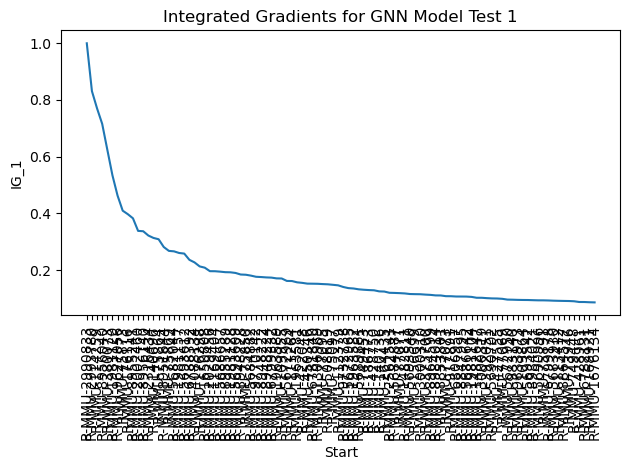

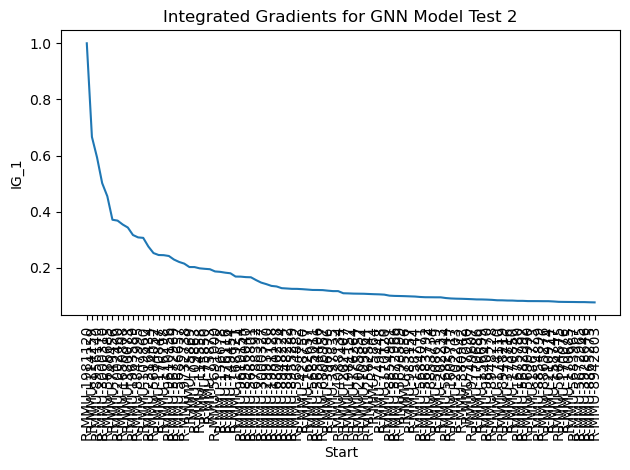

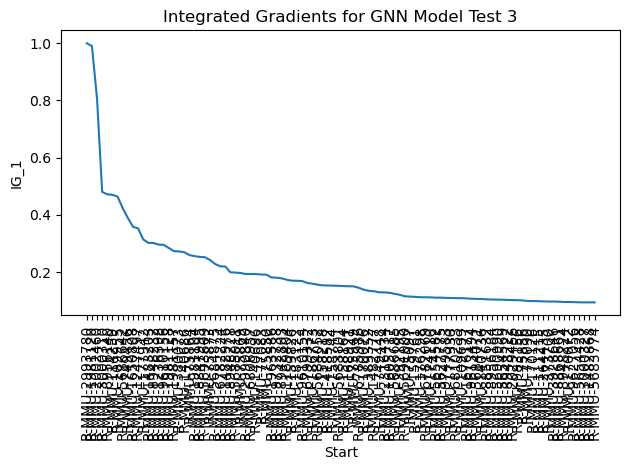

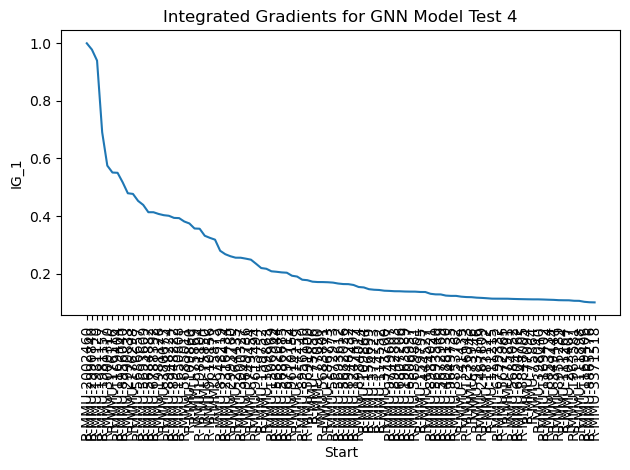

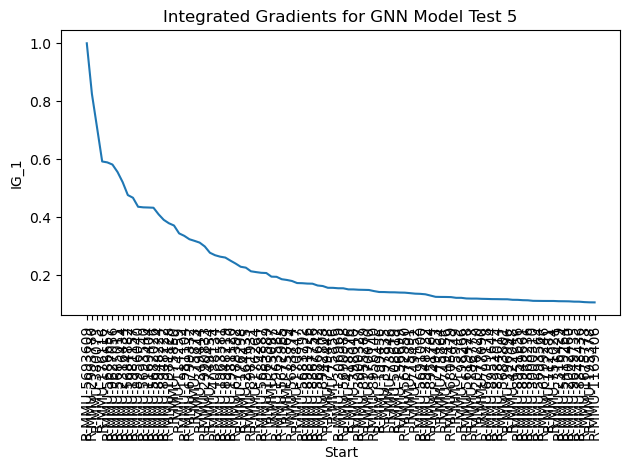

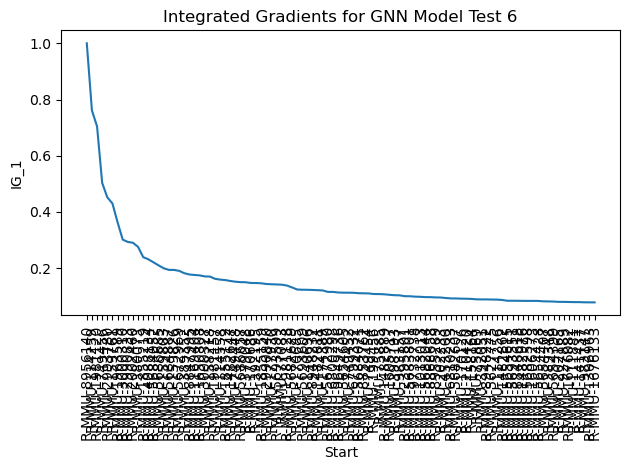

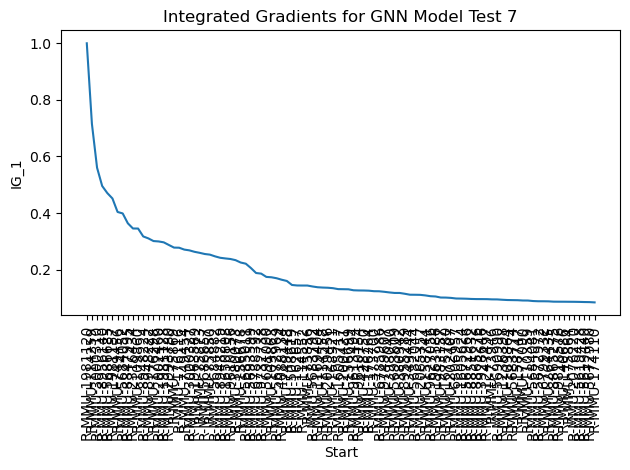

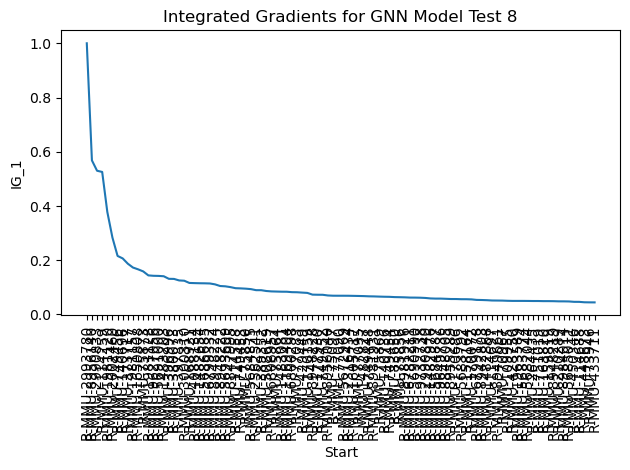

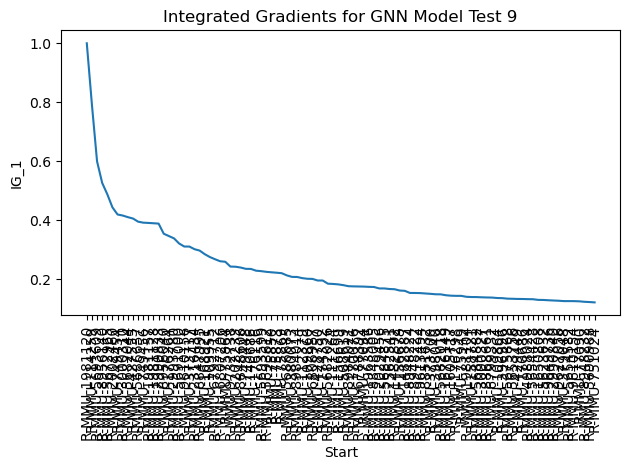

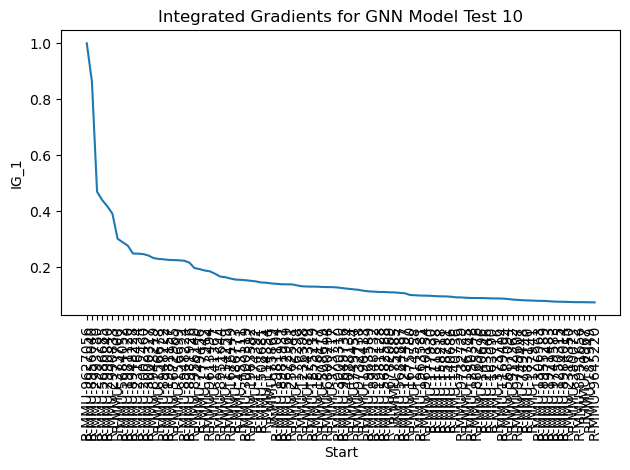

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 定义文件路径模板
file_template = '/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_90{}.csv'

# 初始化列表以存储数据框
data_frames = []

# 读取所有数据并存储在列表中
for i in range(10):
    file_path = file_template.format(i)
    # 检查文件是否存在
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, header=0, sep="\t")
        data_frames.append(df)
    else:
        print(f"File not found: {file_path}")

for i, df in enumerate(data_frames):
    df = df.drop_duplicates(subset='start', keep='first')
    plt.figure()
    plt.plot(df["start"][:100], df["ig_1"][:100], label=f'Test {i+1}')  # 假设 'ig_1' 列是第2列 (列索引为1)
    plt.xlabel('Start')
    plt.ylabel('IG_1')
    plt.title(f'Integrated Gradients for GNN Model Test {i+1}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



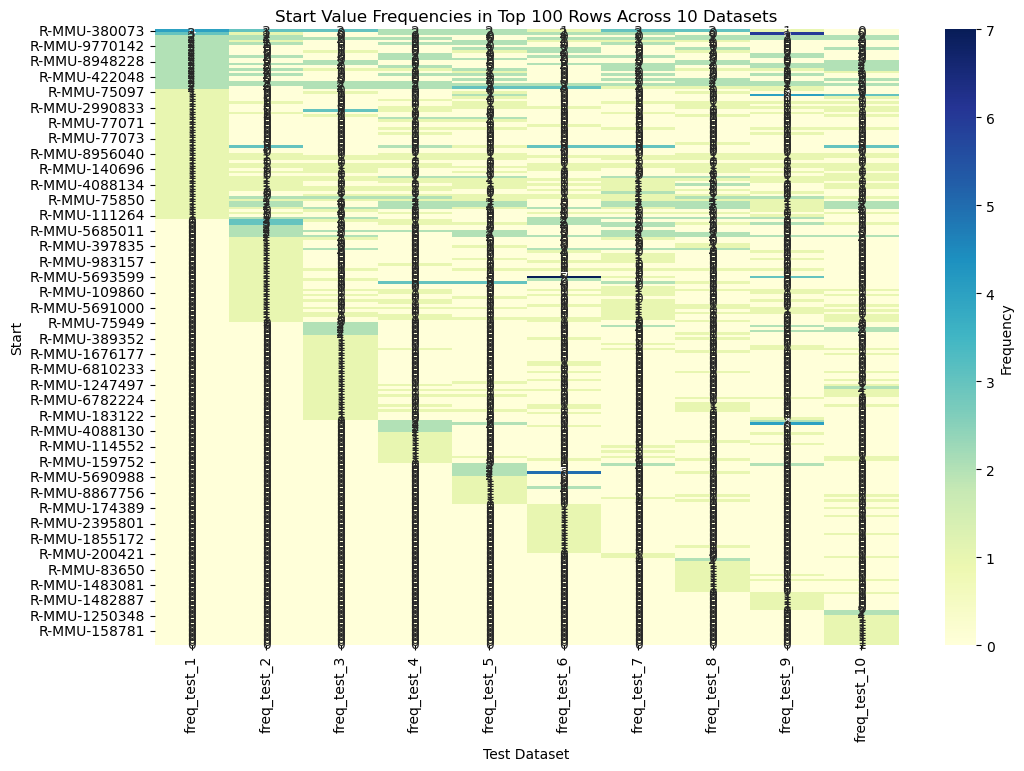

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_template = '/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_90{}.csv'

data_frames = []

for i in range(10):
    file_path = file_template.format(i)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, header=0, sep="\t")
        data_frames.append(df)
    else:
        print(f"File not found: {file_path}")

start_counts = pd.DataFrame()

for i, df in enumerate(data_frames):
    df_top100 = df.head(100)
    start_freq = df_top100['start'].value_counts().reset_index()
    start_freq.columns = ['start', f'freq_test_{i+1}']
    if start_counts.empty:
        start_counts = start_freq
    else:
        start_counts = pd.merge(start_counts, start_freq, on='start', how='outer')

start_counts.fillna(0, inplace=True)

start_counts.set_index('start', inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(start_counts, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Frequency'}, linewidths=0)
plt.title('Start Value Frequencies in Top 100 Rows Across 10 Datasets')
plt.ylabel('Start')
plt.xlabel('Test Dataset')
plt.show()


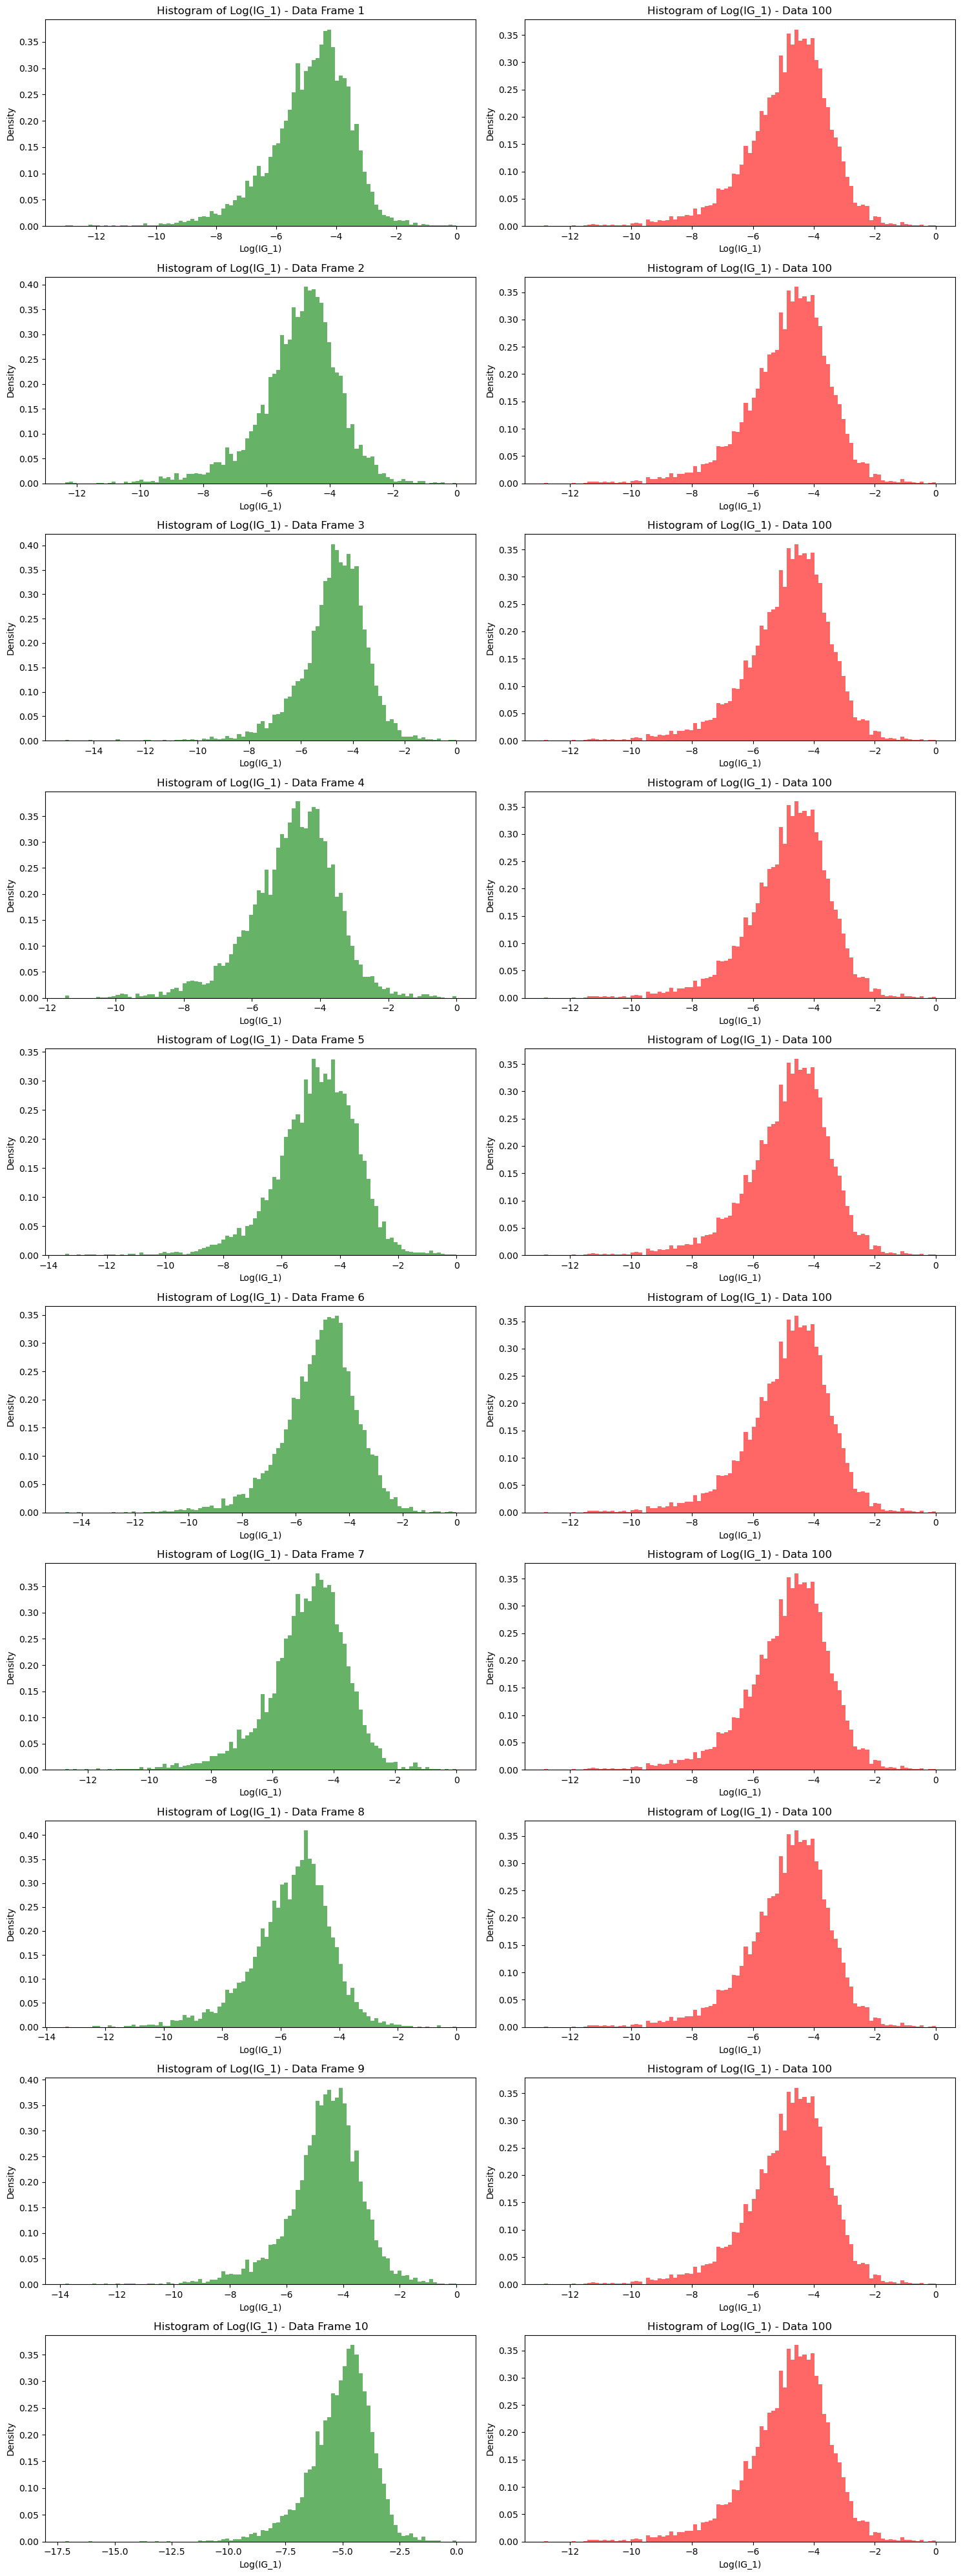

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_100 = pd.read_csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/output/sorted_by_ig1030_time_cross.csv", header=0, sep="\t")
log_ig_1_data_100 = np.log(data_100['ig_1'])

fig, axs = plt.subplots(10, 2, figsize=(15, 40))  

for i, df in enumerate(data_frames):
    log_ig_1 = np.log(df['ig_1'])
    axs[i, 0].hist(log_ig_1, bins=100, density=True, alpha=0.6, color='g')
    axs[i, 0].set_xlabel('Log(IG_1)')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].set_title(f'Histogram of Log(IG_1) - Data Frame {i+1}')
    
    axs[i, 1].hist(log_ig_1_data_100, bins=100, density=True, alpha=0.6, color='r')
    axs[i, 1].set_xlabel('Log(IG_1)')
    axs[i, 1].set_ylabel('Density')
    axs[i, 1].set_title('Histogram of Log(IG_1) - Data 100')

plt.tight_layout()

plt.show()


In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(ggplot2)
library(readr)
library(gridExtra)
library(dplyr)

ig_900 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_900.csv", sep="\t")
ig_901 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_901.csv", sep="\t")
ig_902 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_902.csv", sep="\t")
ig_903 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_903.csv", sep="\t")
ig_904 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_904.csv", sep="\t")
ig_905 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_905.csv", sep="\t")
ig_906 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_906.csv", sep="\t")
ig_907 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_907.csv", sep="\t")
ig_908 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_908.csv", sep="\t")
ig_909 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/learning_curve_analysis/output/sorted_by_ig1030_time_cross_909.csv", sep="\t")
ig_100 <- read.csv("/mnt/home/yuankeji/RanceLab/reticula_new/reticula/data/tcdd/output/sorted_by_ig1030_time_cross.csv", sep="\t")


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [ ]:
%%R
file_list <- list(
  ig_900 = ig_900, 
  ig_901 = ig_901, 
  ig_902 = ig_902, 
  ig_903 = ig_903, 
  ig_904 = ig_904, 
  ig_905 = ig_905, 
  ig_906 = ig_906, 
  ig_907 = ig_907, 
  ig_908 = ig_908, 
  ig_909 = ig_909
)

base_ig <- ig_900$ig_1

pearson_correlations <- list()

for (i in seq_along(file_list)) {
  file_name <- names(file_list)[i]
  if (file_name != "ig_900") {  
    result <- cor.test(base_ig, file_list[[i]]$ig_1, method = "pearson")
    pearson_correlations[[i - 1]] <- list(
      comparison = paste("ig_900_vs", file_name, sep = "_"),
      rho = result$estimate,
      p_value = result$p.value,
      t_value = result$statistic
    )
  }
}

print("------pearson_correlations-------")
for (res in pearson_correlations) {
  print(paste0(res$comparison, ": rho = ", round(res$rho, 4), ", p-value = ", format(res$p_value, scientific = TRUE), ", t-value = ", res$t_value))
}


[1] "------pearson_correlations-------"
[1] "ig_900_vs_ig_901: rho = 0.9952, p-value = 0e+00, t-value = 937.08888537444"
[1] "ig_900_vs_ig_902: rho = 0.9877, p-value = 0e+00, t-value = 584.717730607313"
[1] "ig_900_vs_ig_903: rho = 0.988, p-value = 0e+00, t-value = 590.644855931367"
[1] "ig_900_vs_ig_904: rho = 0.985, p-value = 0e+00, t-value = 527.452661200581"
[1] "ig_900_vs_ig_905: rho = 0.9915, p-value = 0e+00, t-value = 703.880432923013"
[1] "ig_900_vs_ig_906: rho = 0.9912, p-value = 0e+00, t-value = 693.426171771055"
[1] "ig_900_vs_ig_907: rho = 0.9646, p-value = 0e+00, t-value = 338.510250223817"
[1] "ig_900_vs_ig_908: rho = 0.978, p-value = 0e+00, t-value = 433.182249817169"
[1] "ig_900_vs_ig_909: rho = 0.9791, p-value = 0e+00, t-value = 445.74598679249"


In [16]:
%%R
data1_unique <-ig_900 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index1 = row_number())

print(data1_unique)

data2_unique <-ig_901 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index2 = row_number())

data3_unique <-ig_902 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index3 = row_number())

data4_unique <-ig_903 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index4 = row_number())

data5_unique <-ig_904 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index5 = row_number())

data6_unique <-ig_905 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index6 = row_number())

data7_unique <-ig_906 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index7 = row_number())

data8_unique <-ig_907 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index8 = row_number())

data9_unique <-ig_908 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index9 = row_number())

data10_unique <-ig_909 %>% 
  group_by(start) %>%
  slice_max(ig_1, with_ties = FALSE) %>%
  ungroup() %>%
  arrange(desc(ig_1)) %>%
  mutate(index10 = row_number())

# A tibble: 4,758 × 5
    ig_0  ig_1 start         end           index1
   <dbl> <dbl> <chr>         <chr>          <int>
 1 1     1     R-MMU-2990833 R-MMU-2993780      1
 2 0.775 0.831 R-MMU-2993780 R-MMU-2993780      2
 3 0.762 0.770 R-MMU-114259  R-MMU-114252       3
 4 0.787 0.716 R-MMU-8956040 R-MMU-8956140      4
 5 0.867 0.625 R-MMU-380073  R-MMU-749454       5
 6 0.529 0.534 R-MMU-1981120 R-MMU-8948231      6
 7 0.754 0.463 R-MMU-9627056 R-MMU-114259       7
 8 0.556 0.410 R-MMU-75873   R-MMU-75891        8
 9 0.381 0.397 R-MMU-176116  R-MMU-6799246      9
10 0.533 0.383 R-MMU-8955241 R-MMU-8955289     10
# ℹ 4,748 more rows
# ℹ Use `print(n = ...)` to see more rows


In [ ]:
%%R
table <- data1_unique %>%
  mutate(index1 = row_number()) %>%  
  left_join(data2_unique, by = "start") %>%
  left_join(data3_unique, by = "start") %>%
  left_join(data4_unique, by = "start") %>%
  left_join(data5_unique, by = "start") %>%
  left_join(data6_unique, by = "start") %>%
  left_join(data7_unique, by = "start") %>%
  left_join(data8_unique, by = "start") %>%
  left_join(data9_unique, by = "start") %>%
  left_join(data10_unique, by = "start") %>%

  select(Reactions = start, index1, index2, index3, index4, index5, index6, index7, index8, index9, index10)

print(table)


In addition: Warning message:
Removed 4558 rows containing missing values or values outside the scale range
(`geom_point()`). 


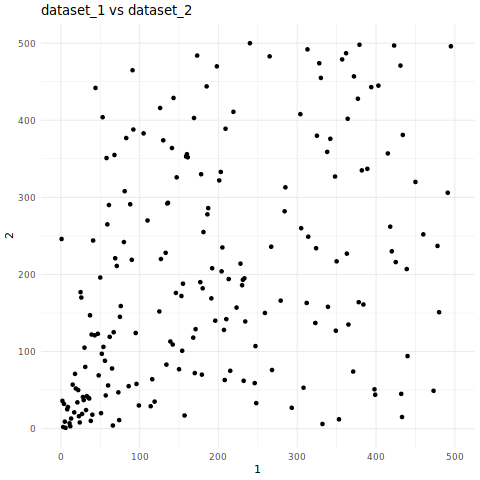

In [22]:
%%R
library(ggplot2)
library(tidyr)

plot_1vs2 <- ggplot((table), aes(x = index1, y = index2)) +
  geom_point() +
  xlim(c(0, 500)) +
  ylim(c(0,500)) +
  labs(title = "dataset_1 vs dataset_2", x = "1", y = "2") +
  theme_minimal()

show(plot_1vs2)

In [44]:
%%R
columns_to_compare <- c("index2", "index3", "index4", "index5", "index6", "index7", "index8", "index9", "index10")
file_names <- c("ig_901", "ig_902", "ig_903", "ig_904", "ig_905", "ig_906", "ig_907", "ig_908", "ig_909")

pearson_correlations <- list()

for (i in seq_along(columns_to_compare)) {
  result <- cor.test(table$index1, table[[columns_to_compare[i]]], method = "pearson")
  
  pearson_correlations[[i]] <- list(
    comparison = paste("ig_900_vs", file_names[i], sep = "_"),
    rho = result$estimate,
    p_value = result$p.value,
    t_value = result$statistic
  )
}

print("------pearson_correlations-------")
for (res in pearson_correlations) {
  print(paste0(res$comparison, ": rho = ", round(res$rho, 4), ", p-value = ", format(res$p_value, scientific = TRUE), ", t-value = ", res$t_value))
}


[1] "------pearson_correlations-------"
[1] "ig_900_vs_ig_901: rho = 0.3554, p-value = 1.226231e-141, t-value = 26.2188243811571"
[1] "ig_900_vs_ig_902: rho = 0.2224, p-value = 2.162272e-54, t-value = 15.7301794364253"
[1] "ig_900_vs_ig_903: rho = 0.4141, p-value = 1.485104e-196, t-value = 31.3743218465968"
[1] "ig_900_vs_ig_904: rho = 0.576, p-value = 0e+00, t-value = 48.5941433969187"
[1] "ig_900_vs_ig_905: rho = 0.2088, p-value = 4.94949e-48, t-value = 14.7259162402547"
[1] "ig_900_vs_ig_906: rho = 0.3493, p-value = 1.355694e-136, t-value = 25.7088872078752"
[1] "ig_900_vs_ig_907: rho = 0.4679, p-value = 1.515805e-257, t-value = 36.5137393079991"
[1] "ig_900_vs_ig_908: rho = 0.3004, p-value = 8.567268e-100, t-value = 21.7175192201834"
[1] "ig_900_vs_ig_909: rho = 0.2779, p-value = 3.837703e-85, t-value = 19.9544240071486"


In [45]:
%%R
columns_to_compare <- c("index2", "index3", "index4", "index5", "index6", "index7", "index8", "index9", "index10")
file_names <- c("ig_901", "ig_902", "ig_903", "ig_904", "ig_905", "ig_906", "ig_907", "ig_908", "ig_909")

spearman_correlations <- list()

for (i in seq_along(columns_to_compare)) {
  result <- cor.test(table$index1, table[[columns_to_compare[i]]], method = "spearman")
  
  spearman_correlations[[i]] <- list(
    comparison = paste("ig_900_vs", file_names[i], sep = "_"),
    rho = result$estimate,
    p_value = result$p.value,
    S_value = result$statistic
  )
}

print("------spearman_correlations-------")
for (res in spearman_correlations) {
  print(paste0(res$comparison, ": rho = ", round(res$rho, 4), ", p-value = ", format(res$p_value, scientific = TRUE), ", S-value = ", res$S_value))
}


[1] "------spearman_correlations-------"
[1] "ig_900_vs_ig_901: rho = 0.3554, p-value = 1.226231e-141, S-value = 11572697946"
[1] "ig_900_vs_ig_902: rho = 0.2224, p-value = 2.162272e-54, S-value = 13960096394"
[1] "ig_900_vs_ig_903: rho = 0.4141, p-value = 1.485104e-196, S-value = 10518299654"
[1] "ig_900_vs_ig_904: rho = 0.576, p-value = 0e+00, S-value = 7611784504"
[1] "ig_900_vs_ig_905: rho = 0.2088, p-value = 4.94949e-48, S-value = 14203500142"
[1] "ig_900_vs_ig_906: rho = 0.3493, p-value = 1.355694e-136, S-value = 11681507046"
[1] "ig_900_vs_ig_907: rho = 0.4679, p-value = 1.515805e-257, S-value = 9552050618"
[1] "ig_900_vs_ig_908: rho = 0.3004, p-value = 8.567268e-100, S-value = 12560019200"
[1] "ig_900_vs_ig_909: rho = 0.2779, p-value = 3.837703e-85, S-value = 12962599406"


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


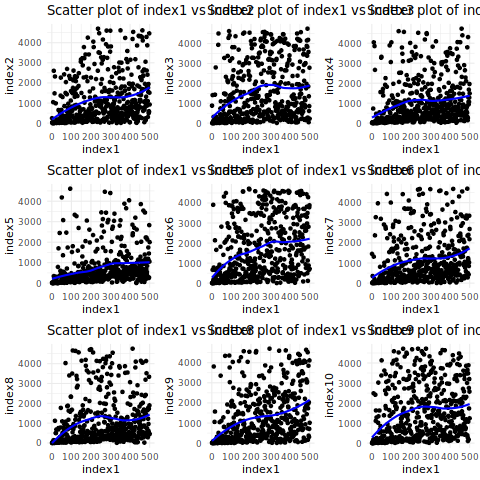

In [ ]:
%%R
library(ggplot2)
library(gridExtra)

columns_to_compare <- c("index2", "index3", "index4", "index5", "index6", "index7", "index8", "index9", "index10")

plots <- lapply(columns_to_compare, function(col) {
  ggplot(head(table, 500), aes_string(x = "index1", y = col)) +
    geom_point() +
    geom_smooth(method = "loess", se = FALSE, color = "blue") +  
    labs(title = paste("Scatter plot of index1 vs", col)) +
    theme_minimal()
})

do.call(grid.arrange, c(plots, ncol = 3))


In [37]:
%%R
spearman_correlation_1 <- cor.test(table$index1, table$index2, method = "spearman")
print(spearman_correlation_1)


	Spearman's rank correlation rho

data:  table$index1 and table$index2
S = 1.1573e+10, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3553669 

